<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/stock-price-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-series forecasting: Apple stock prediction


In [24]:
!pip install yfinance --quiet

In [66]:
import yfinance as yf
import pandas as pd
import numpy as np
# getting data from Yahoo Finance
stock_name = 'AAPL'
data = yf.download(stock_name, start="2016-01-01", end="2025-04-01")

[*********************100%***********************]  1 of 1 completed


In [67]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2016-01-04,23.834381,23.838907,23.076478,23.214484,270597600
2016-01-05,23.237108,23.947502,23.169237,23.924878,223164000
2016-01-06,22.782366,23.160188,22.594588,22.750692,273829600
2016-01-07,21.820839,22.653402,21.816315,22.325355,324377600
2016-01-08,21.936222,22.422638,21.890975,22.295944,283192000


In [68]:
data.tail()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-03-25,223.750000,224.100006,220.080002,220.770004,34493600
2025-03-26,221.529999,225.020004,220.470001,223.509995,34466100
2025-03-27,223.850006,224.990005,220.559998,221.389999,37094800
2025-03-28,217.899994,223.809998,217.679993,221.669998,39818600
2025-03-31,222.130005,225.619995,216.229996,217.009995,65299300


In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2324 entries, 2016-01-04 to 2025-03-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   2324 non-null   float64
 1   (High, AAPL)    2324 non-null   float64
 2   (Low, AAPL)     2324 non-null   float64
 3   (Open, AAPL)    2324 non-null   float64
 4   (Volume, AAPL)  2324 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 108.9 KB


In [70]:
data['close price']=data['Close']
data.index=pd.to_datetime(data.index)


In [71]:
data.drop(columns=['Open','High','Close','Low'],inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2324 entries, 2016-01-04 to 2025-03-31
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Volume, AAPL)   2324 non-null   int64  
 1   (close price, )  2324 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 54.5 KB


In [72]:
data.head()

Price,Volume,close price
Ticker,AAPL,
Date,,
2016-01-04,270597600,23.834381
2016-01-05,223164000,23.237108
2016-01-06,273829600,22.782366
2016-01-07,324377600,21.820839
2016-01-08,283192000,21.936222


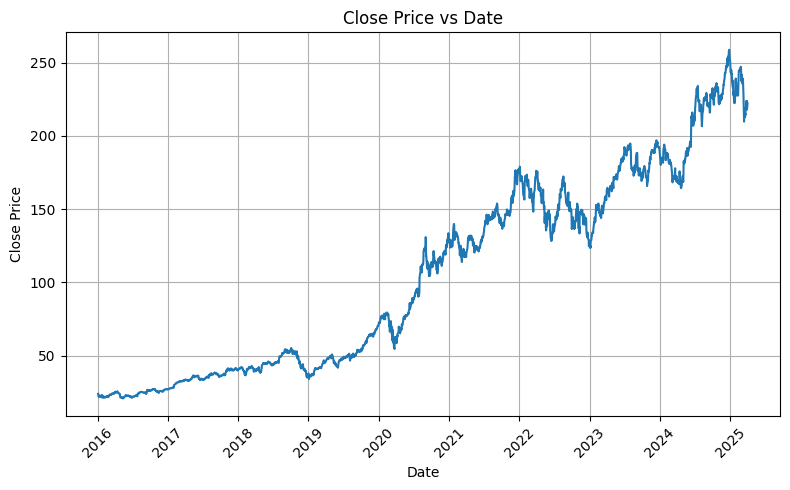

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(data.index, data['close price'])
plt.title('Close Price vs Date')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

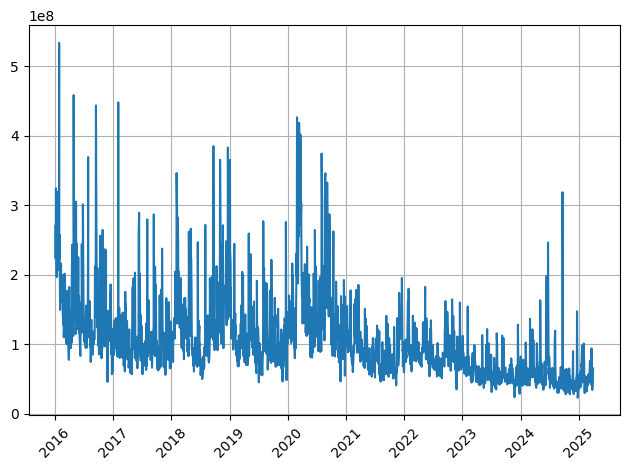

In [74]:
plt.plot(data.index, data['Volume'])
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# XGB regression

In [75]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Extract useful Date features
data['day'] = data.index.day
data['month'] = data.index.month
data['year'] = data.index.year
data['dayofweek'] = data.index.dayofweek

# Define features and target
X = data[['Volume', 'day', 'month', 'year', 'dayofweek']]
y = data[['close price']]
X.head()

Price,Volume,day,month,year,dayofweek
Ticker,AAPL,,,,
Date,,,,,
2016-01-04,270597600,4,1,2016,0
2016-01-05,223164000,5,1,2016,1
2016-01-06,273829600,6,1,2016,2
2016-01-07,324377600,7,1,2016,3
2016-01-08,283192000,8,1,2016,4


In [76]:
y

Price,close price
Ticker,
Date,
2016-01-04,23.834381
2016-01-05,23.237108
2016-01-06,22.782366
2016-01-07,21.820839
2016-01-08,21.936222
...,...
2025-03-25,223.750000
2025-03-26,221.529999


In [77]:
# Number of past and future days for lag/lead
lags = [1, 5, 7, 10, 30]
rolls = [3, 7, 14]

# LAG FEATURES (past prices and volumes)
for lag in lags:
    X[f'close_lag_{lag}'] = y['close price'].shift(lag)

# ROLLING MEAN FEATURES (trend indicators)
for r in rolls:
    X[f'close_roll_mean_{r}'] = y['close price'].rolling(window=r).mean()

X.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2324 entries, 2016-01-04 to 2025-03-31
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   (Volume, AAPL)          2324 non-null   int64  
 1   (day, )                 2324 non-null   int32  
 2   (month, )               2324 non-null   int32  
 3   (year, )                2324 non-null   int32  
 4   (dayofweek, )           2324 non-null   int32  
 5   (close_lag_1, )         2323 non-null   float64
 6   (close_lag_5, )         2319 non-null   float64
 7   (close_lag_7, )         2317 non-null   float64
 8   (close_lag_10, )        2314 non-null   float64
 9   (close_lag_30, )        2294 non-null   float64
 10  (close_roll_mean_3, )   2322 non-null   float64
 11  (close_roll_mean_7, )   2318 non-null   float64
 12  (close_roll_mean_14, )  2311 non-null   float64
dtypes: float64(8), int32(4), int64(1)
memory usage: 217.9 KB


In [78]:
X.head()

Price,Volume,day,month,year,dayofweek,close_lag_1,close_lag_5,close_lag_7,close_lag_10,close_lag_30,close_roll_mean_3,close_roll_mean_7,close_roll_mean_14
Ticker,AAPL,,,,,,,,,,,,
Date,,,,,,,,,,,,,
2016-01-04,270597600,4,1,2016,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,223164000,5,1,2016,1,23.834381,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,273829600,6,1,2016,2,23.237108,NaN,NaN,NaN,NaN,23.284618,NaN,NaN
2016-01-07,324377600,7,1,2016,3,22.782366,NaN,NaN,NaN,NaN,22.613438,NaN,NaN
2016-01-08,283192000,8,1,2016,4,21.820839,NaN,NaN,NaN,NaN,22.179809,NaN,NaN


In [79]:
# Drop rows with NaN values caused by shift/rolling
data.dropna(inplace=True)

In [87]:
from sklearn.model_selection import train_test_split
# Train-test split without shuffle for time-series
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
print("Testing Dates:", len(X_test))
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, shuffle=False)
print("Training Dates:", len(X_train))
print("val Dates:", len(X_val))
X_train.head()

Testing Dates: 233
Training Dates: 1672
val Dates: 419


Price,Volume,day,month,year,dayofweek,close_lag_1,close_lag_5,close_lag_7,close_lag_10,close_lag_30,close_roll_mean_3,close_roll_mean_7,close_roll_mean_14
Ticker,AAPL,,,,,,,,,,,,
Date,,,,,,,,,,,,,
2016-01-04,270597600,4,1,2016,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,223164000,5,1,2016,1,23.834381,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,273829600,6,1,2016,2,23.237108,NaN,NaN,NaN,NaN,23.284618,NaN,NaN
2016-01-07,324377600,7,1,2016,3,22.782366,NaN,NaN,NaN,NaN,22.613438,NaN,NaN
2016-01-08,283192000,8,1,2016,4,21.820839,NaN,NaN,NaN,NaN,22.179809,NaN,NaN


In [88]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit on training features only (to avoid data leakage)
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train

array([[0.46620809, 0.1       , 0.        , ...,        nan,        nan,
               nan],
       [0.36989206, 0.13333333, 0.        , ...,        nan,        nan,
               nan],
       [0.47277081, 0.16666667, 0.        , ..., 0.01560069,        nan,
               nan],
       ...,
       [0.05958896, 0.6       , 0.63636364, ..., 0.96445246, 0.95981129,
        0.95289077],
       [0.05690966, 0.7       , 0.63636364, ..., 0.94971629, 0.95897615,
        0.95648901],
       [0.02669577, 0.73333333, 0.63636364, ..., 0.93510682, 0.95455533,
        0.9571042 ]])

In [89]:
!pip install optuna

In [90]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error

# Create study
study = optuna.create_study(direction="minimize")

# Loop over trials
for _ in range(50):
    # Ask for a new trial
    trial = study.ask()

    # Suggest hyperparameters using trial object
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'random_state': 42
    }

    # Train and evaluate model
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, preds)

    # Report result
    study.tell(trial, rmse)

# Best result
print("Best RMSE:", study.best_value)
print("Best Parameters:", study.best_params)


[I 2025-04-30 19:00:21,765] A new study created in memory with name: no-name-26a915b5-d9e6-4927-aa10-b3581823b59e


Best RMSE: 6.7314629554748535
Best Parameters: {'n_estimators': 430, 'learning_rate': 0.09922865804643094, 'max_depth': 3, 'subsample': 0.7242386271822281, 'colsample_bytree': 0.8937373746198595, 'gamma': 0.3142430096903925, 'min_child_weight': 4}


In [91]:
best_params = study.best_params
best_params['random_state'] = 42
final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train)  # or X_train, y_train if you want
# Example: Predict on same training data (for demo)
y_pred = final_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print("Final RMSE on training set:", rmse)

Final RMSE on training set: 49.12583923339844


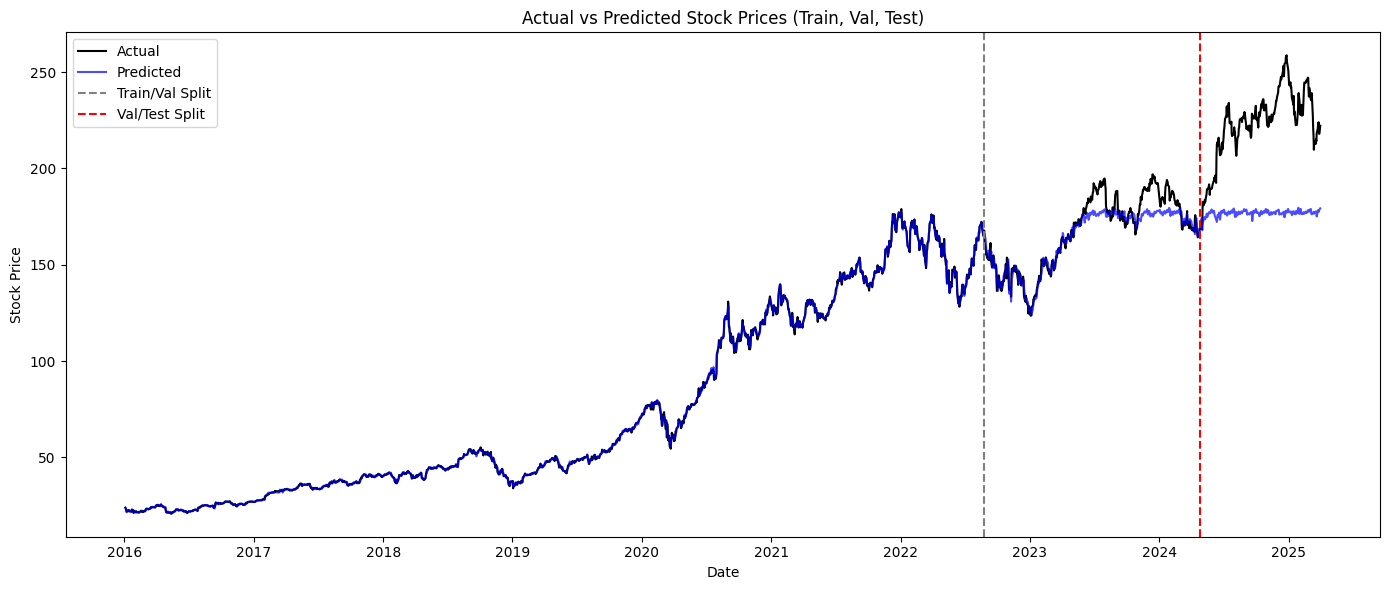

In [92]:
# 3. Make predictions
train_pred = final_model.predict(X_train)
val_pred = final_model.predict(X_val)
test_pred = final_model.predict(X_test)

train_size = int(len(X_train))
val_size = int(len(X_val))
test_size = int(len(X_test))

# 4. Create a DataFrame for plotting
pred_df = pd.DataFrame({
    'date': X.index,  # original DataFrame index was datetime
    'actual': y.values.ravel(),
    'set': ['train'] * len(y_train) + ['val'] * len(y_val) + ['test'] * len(y_test),
    'predicted': list(train_pred) + list(val_pred) + list(test_pred)
})

# 5. Plot
plt.figure(figsize=(14, 6))
plt.plot(pred_df['date'], pred_df['actual'], label='Actual', color='black')
plt.plot(pred_df['date'], pred_df['predicted'], label='Predicted', color='blue', alpha=0.7)
plt.axvline(pred_df['date'].iloc[train_size], color='gray', linestyle='--', label='Train/Val Split')
plt.axvline(pred_df['date'].iloc[train_size + val_size], color='red', linestyle='--', label='Val/Test Split')
plt.title("Actual vs Predicted Stock Prices (Train, Val, Test)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.tight_layout()
plt.show()

In [93]:
....

SyntaxError: invalid syntax (<ipython-input-93-7834bfc346aa>, line 1)

# facebook Prophet model

In [ ]:
!pip uninstall prophet
!pip uninstall fbprophet
!pip uninstall pystan
!pip uninstall cmdstanpy
!pip install pystan==2.19.1.1
!pip install prophet==1.1.1

In [ ]:
from prophet import Prophet

from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid

prophet_data=data.reset_index()
prophet_data=prophet_data.rename(columns={'Date':'ds','close price':'y'})
prophet_data.head()

In [ ]:
# 2. Train-Validation-Test Split
train_size = int(0.7 * len(prophet_data))  # 70% train
val_size = int(0.15 * len(prophet_data))   # 15% validation
train_df = prophet_data[:train_size]
val_df = prophet_data[train_size:train_size+val_size]
test_df = prophet_data[train_size+val_size:]

print(f'Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}')


In [ ]:
params_grid = {
    'seasonality_mode': ('multiplicative', 'additive'),
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'holidays_prior_scale': [0.01, 0.1, 1.0],
    'n_changepoints': [10, 20, 50]
}

grid = list(ParameterGrid(params_grid))
print(f'Total combinations: {len(grid)}')

# --- Cross-validation (manual) for hyperparameter tuning ---
best_params = None
best_val_mae = float('inf')

for params in grid:
    try:
        # Define model with current params
        model = Prophet(
            seasonality_mode=params['seasonality_mode'],
            changepoint_prior_scale=params['changepoint_prior_scale'],
            holidays_prior_scale=params['holidays_prior_scale'],
            n_changepoints=params['n_changepoints']
        )

        # Fit on training data
        model.fit(train_df)

        # Make future dataframe covering validation set
        future = val_df[['ds']].copy()
        forecast = model.predict(future)

        # Make sure 'yhat' is in forecast columns
        if 'yhat' not in forecast.columns:
            print(f"⚠️ Skipping params {params} because 'yhat' missing in forecast.")
            continue

        # Evaluation on validation set
        val_pred = forecast['yhat'].values
        val_true = val_df['y'].values

        val_mae = mean_absolute_error(val_true, val_pred)
        val_rmse = mean_squared_error(val_true, val_pred, squared=False)

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_params = params

    except Exception as e:
        print(f"⚠️ Skipping params {params} due to error: {e}")
        continue




In [ ]:
print("\nBest Hyperparameters:")
print(best_params)
print(f'Best Validation MAE: {best_val_mae:.4f}')

In [ ]:
# --- Check for Overfitting ---
# Train error
best_model = Prophet(
    seasonality_mode=best_params['seasonality_mode'],
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    n_changepoints=best_params['n_changepoints']
)

best_model.fit(train_df)

# Predict on training set
train_future = train_df[['ds']]
train_forecast = best_model.predict(train_future)

train_mae = mean_absolute_error(train_df['y'], train_forecast['yhat'])
train_rmse = mean_squared_error(train_df['y'], train_forecast['yhat'], squared=False)

print(f"\nTraining MAE: {train_mae:.4f}")
print(f"Validation MAE: {best_val_mae:.4f}")

if abs(train_mae - best_val_mae) > 0.1 * train_mae:
    print("⚠️  Possible overfitting detected (big train vs val error gap).")
else:
    print("✅ No major overfitting detected.")



In [ ]:
# --- Final Testing on unseen data ---
full_df = pd.concat([train_df, val_df])

final_model = Prophet(
    seasonality_mode=best_params['seasonality_mode'],
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    n_changepoints=best_params['n_changepoints']
)

final_model.fit(full_df)

future = test_df[['ds']]
forecast = final_model.predict(future)

test_pred = forecast['yhat'].values
test_true = test_df['y'].values

test_mae = mean_absolute_error(test_true, test_pred)
test_rmse = mean_squared_error(test_true, test_pred, squared=False)

print(f"\nTest MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# --- Plot forecast vs actual prices on test set ---
plt.figure(figsize=(12,6))
plt.plot(test_df['ds'], test_true, label='Actual')
plt.plot(test_df['ds'], test_pred, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Forecast vs Actual Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()


# creating lag features to be used for DNN and ensemble methods

In [ ]:
lags = [1, 7, 30, 365]  # Example: 1-day, 2-day, 5-day, 10-day lags

for lag in lags:
    data[f'Close_lag_{lag}'] = data['close price'].shift(lag)

In [ ]:
data = data.dropna()
data.head()

In [ ]:
data.tail()

In [ ]:
data['date_column']=data.index
data['day'] = data['date_column'].dt.day
data['month'] = data['date_column'].dt.month
data['year'] = data['date_column'].dt.year
data['weekday'] = data['date_column'].dt.day_name()  # Gives full weekday name (e.g., "Thursday")
#data.drop(columns=['date_column'],inplace=True)
data.head()

In [ ]:
data.tail()

In [ ]:
#Cyclic Encoding (Best for LSTMs and Time-Series)
#Best for LSTM models, as it captures the cyclic nature of time-based data.
#Transforms features into sine and cosine to preserve periodicity.
# Convert time-based features into cyclic representation
data['day_sin'] = np.sin(2 * np.pi * data['day'] / 31)
data['day_cos'] = np.cos(2 * np.pi * data['day'] / 31)

data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

data['year_sin'] = np.sin(2 * np.pi * data['year'] / 365)
data['year_cos'] = np.cos(2 * np.pi * data['year'] / 365)
data.drop(columns=['day','month','year'],inplace=True)
data.head()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[['close price',	'Close_lag_1',	'Close_lag_7',	'Close_lag_30',	'Close_lag_365',	'day_sin',	'day_cos', 'month_sin', 'month_cos',	'year_sin',	'year_cos', 'weekday']], data['close price'], test_size=0.2, shuffle=False)
print("Training Dates:", len(X_train))
print("Testing Dates:", len(X_test))
X_train.head()

A lag is a time delay or offset in a time series, representing a past value of a variable used to predict its future values.
Example:
If you're forecasting sales, a lag of 1 might mean using last month's sales to predict this month's sales.
Purpose:
Lags help capture the relationships between past and future values of a variable, which can be crucial for accurate forecasting.

ARIMA, SARIMA, and Temporal Fusion Transformer (TFT) Models:

ARIMA (Autoregressive Integrated Moving Average):
A statistical model that uses past values of a time series (autoregressive), differencing to achieve stationarity (integrated), and past forecast errors (moving average) to predict future values.
Strengths: Can handle a wide range of time series patterns, including trends and seasonality.
Limitations: Assumes linear relationships and may struggle with complex patterns.

SARIMA (Seasonal ARIMA):
An extension of ARIMA that incorporates seasonal patterns in the data.
Strengths: Captures both non-seasonal and seasonal patterns in the data.
Limitations: Still assumes linear relationships and may struggle with complex patterns.

Temporal Fusion Transformer (TFT):
A deep learning model that uses self-attention mechanisms to capture complex temporal patterns across multiple time sequences.
Strengths: Can handle complex patterns, multi-horizon forecasting, and interpretability through attention mechanisms.
Limitations: Requires a large amount of data and can be computationally expensive

# LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
X_train.loc[:, ['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Close_lag_365']] = scaler.fit_transform(
    X_train.loc[:, ['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Close_lag_365']]
)

X_test.loc[:, ['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Close_lag_365']] = scaler.transform(
    X_test.loc[:, ['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Close_lag_365']]
)
X_train = pd.get_dummies(X_train, columns=['weekday'], drop_first=True)  # drop_first to avoid dummy variable trap
X_test = pd.get_dummies(X_test, columns=['weekday'], drop_first=True)

X_train.head()

In [ ]:
X_test.head()

In [ ]:
print(X_train.shape, X_test.shape)

In [ ]:
X_train.shape[0]

In [ ]:
time_steps = 1
# Calculate how many complete sequences you can create
num_samples = X_train.shape[0] // time_steps
# Reshape the data accordingly
X_train_reshaped = X_train.values[:num_samples * time_steps].reshape((num_samples, time_steps, X_train.shape[1]))
print(X_train_reshaped.shape)

In [ ]:
# Ensure your test data is reshaped similarly to the training data
# Calculate the number of full sequences in the test data
num_samples_test = X_test.shape[0] // time_steps
# Reshape X_test into the same shape as X_train_reshaped
X_test_reshaped = X_test.values[:num_samples_test * time_steps].reshape((num_samples_test, time_steps, X_test.shape[1]))
# Check the new shape of X_test_reshaped
print(X_test_reshaped.shape)

In [ ]:
X_train_reshaped.dtype
# Ensure that your features (X_train_reshaped) are of numeric type
X_train_reshaped = X_train_reshaped.astype('float32')

# Ensure that your target variable (y_train) is of numeric type
y_train = y_train.astype('float32')

# Similarly, apply the same for validation data if needed
X_test_reshaped = X_test_reshaped.astype('float32')
y_test = y_test.astype('float32')

In [ ]:
# Define the model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),  # (time_steps, features)
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train, epochs=500, batch_size=1000, validation_data=(X_test_reshaped, y_test))


In [ ]:
# Predict on test data
y_pred = model.predict(X_test)

# Convert predictions back to original scale
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs. predicted prices
plt.figure(figsize=(10,6))
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual Prices")
plt.plot(df.index[-len(y_pred_actual):], y_pred_actual, label="Predicted Prices")
plt.legend()
plt.title("Stock Price Prediction with LSTM")
plt.show()